<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 2.3 Modelos compartimentales y en tiempo discreto </h3>
<h3 style="text-align: center;"> Ejercicios propuestos </h3>

## Ejercicio 1

Partimos del modelo *SIR*, asumiendo individuos homogéneos con red de contactos total. Las ecuaciones que rigen el modelo son 

$$\begin{aligned}
\frac{ds}{dt} &= -\beta s x  \\
\frac{dx}{dt} &= \beta s x - \gamma x\\
\frac{dr}{dt} &= \gamma x,
\end{aligned}$$ 

donde $s$, $x$, $r$ son el porcentaje de susceptibles, infectados y recuperados en la población. El parámetro $\beta$ es la tasa de contagio entre los contactos posibles y $\gamma = 1/T$, siendo $T$ la duración de la enfermedad. 

(desglosar x en x1, x2, x3,... en un periodo de 7 dias) hay que cambiar las variables en las funciones
Que variables necesitamos? Hay que contabilizar los enfermos de cada dia, por lo que necesitamos una variable para cada dia. Cada variable representa una ecuación diferencial. 
Comparar el calculo de infectados con Xdesagregado (suma de X1, X2,..,X7) y con Xagregado (X) en un periodo de 7 dias.

**Apartado 1.** Extender el modelo asumiendo que $T$ indica la duración exacta de la enfermedad, contabilizando los enfermos que llevan $d$ días desde que enfermaron, con $1<d \leq T$. Tomar como parámetros del modelo los utilizados en los ejercicios de clase. (a) Escribir las ecuaciones del modelo; (b) Comparar la evolución del número total de susceptibles, infectados y recuperados de este modelo extendido con el modelo original; (c) Representar gráficamente las diferencias entre las salidas de un modelo y otro (e.g, número total de infectados) en función de la duración de la enfermedad y otros parámetros.   

(vamos a suponer que vacunamos a un numero concreto, p, de personas cada dia. No un porcentaje)

**Apartado 2.** Incluir un proceso de inmunización a partir del modelo SIR presentado en el enunciado. Dada una población $N$ de individuos, asumir que se vacuna un número fijo $p$ de personas cada día. (a) Escribir las ecuaciones del modelo (es necesario para ello re-escribir el modelo SIR para poblaciones $S$, $X$, $R$, donde $S+X+R=N$); (b) Comparar la evolución del número total de susceptibles, infectados y recuperados de este modelo extendido con el modelo SIR original con inmunización, donde se vacunan un porcentaje determinado de la poblacion; (c) Encontrar el número mínimo de vacunados $p^*$ para los que se alcanza la inmunidad de rebaño, o sea, la enfermedad no llega a desarrollarse o lo hace muy levemente; (d) Estudiar ese nivel mínimo de vacunados en función del tamaño de la población $N$ (representar $p^*/N$ en función de $N$). 

## Apartado 1:

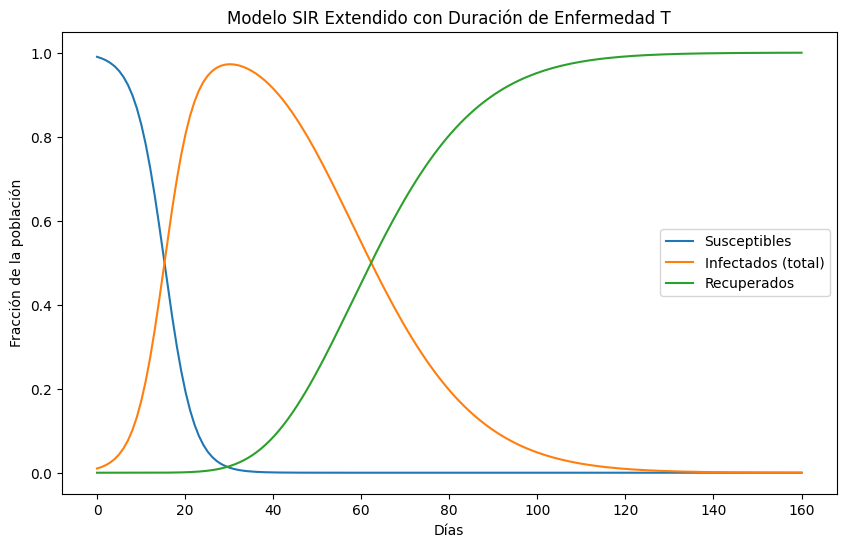

In [12]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros del modelo
re = 3         # numero de encuentros por día
ri = 0.1       # tasas de infección
beta = re*ri   # tasa de contacto por día
T = 7          # duración de la enfermedad en días
gamma = 1 / T  # tasa de recuperación

# Condiciones iniciales
s0 = 0.99  # fracción inicial de susceptibles
x0 = [0.01] + [0] * (T - 1)  # fracción inicial de infectados en cada día de infección (solo en x_1 hay infectados inicialmente)
r0 = 0     # fracción inicial de recuperados

# Vector inicial de estado
initial_conditions = [s0] + x0 + [r0]

# Sistema de ecuaciones diferenciales
def model(y, t, beta, gamma, T):
    s = y[0]  # susceptibles
    x = y[1:T+1]  # infectados en cada día de la enfermedad
    r = y[T+1]  # recuperados

    # Ecuación para los susceptibles
    ds_dt = -beta * s * sum(x)

    # Ecuaciones para los infectados en cada día d
    dx_dt = [0] * T
    dx_dt[0] = beta * s * sum(x) - x[0] / T  # Primer día de infección
    for d in range(1, T-1):
        dx_dt[d] = x[d-1] / T - x[d] / T  # Transición entre días de infección
    dx_dt[T-1] = x[T-2] / T - gamma * x[T-1]  # Último día de infección

    # Ecuación para los recuperados
    dr_dt = gamma * x[T-1]

    return [ds_dt] + dx_dt + [dr_dt]

# Tiempo de simulación
days = 160  # número de días a simular
t = np.linspace(0, days, days)

# Resolución del sistema de ecuaciones diferenciales
solution = odeint(model, initial_conditions, t, args=(beta, gamma, T))
s = solution[:, 0]
x = solution[:, 1:T+1]
r = solution[:, T+1]

# Gráfica de resultados
plt.figure(figsize=(10, 6))
plt.plot(t, s, label='Susceptibles')
plt.plot(t, np.sum(x, axis=1), label='Infectados (total)')
#for d in range(T):
    #plt.plot(t, x[:, d], label=f'Infectados día {d+1}')
plt.plot(t, r, label='Recuperados')
plt.xlabel('Días')
plt.ylabel('Fracción de la población')
plt.legend()
plt.title('Modelo SIR Extendido con Duración de Enfermedad T')
plt.show()


### Apartado 2:

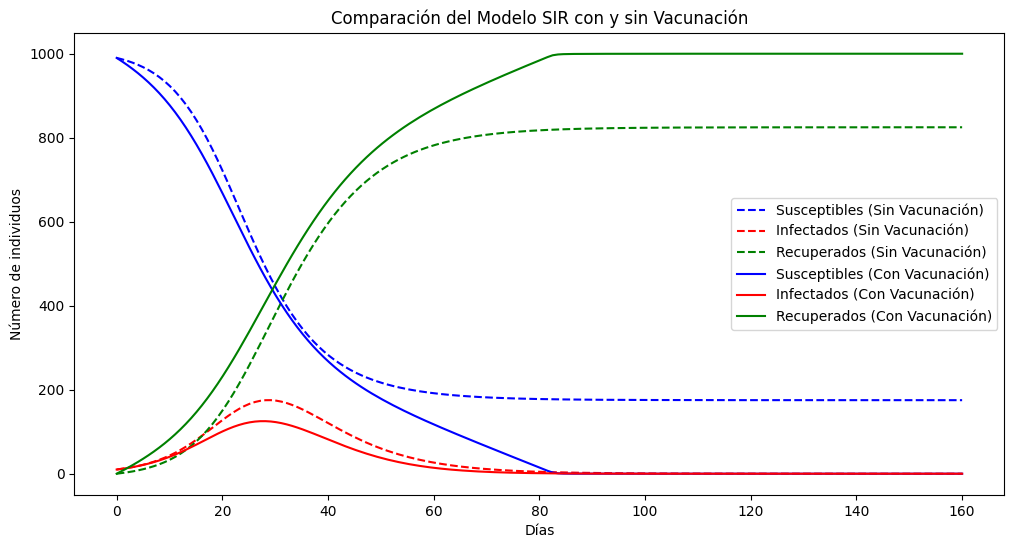

In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parámetros del modelo
N = 1000        # tamaño de la población
re = 3          # número de encuentros por día por persona
ri = 0.1        # tasa de infección por encuentro
beta = re * ri  # tasa de contacto por día
T = 7           # duración de la enfermedad en días
gamma = 1 / T   # tasa de recuperación
p = 5           # número de personas vacunadas cada día

# Condiciones iniciales
S0 = N - 10     # susceptibles iniciales (la mayoría de la población)
X0 = 10         # infectados iniciales
R0 = 0          # recuperados iniciales

# --- Modelo SIR sin vacunación ---
def sir_model(y, t, beta, gamma, N):
    S, X, R = y
    dS_dt = -beta * S * X / N
    dX_dt = beta * S * X / N - gamma * X
    dR_dt = gamma * X
    return [dS_dt, dX_dt, dR_dt]

# --- Modelo SIR con vacunación ---
def sir_vacunacion_model(y, t, beta, gamma, N, p):
    S, X, R = y
    # Asegurarse de no vacunar más susceptibles de los que hay
    vacunados = min(S, p)
    dS_dt = -beta * S * X / N - vacunados
    dX_dt = beta * S * X / N - gamma * X
    dR_dt = gamma * X + vacunados
    return [dS_dt, dX_dt, dR_dt]

# Condiciones iniciales para ambos modelos
initial_conditions = [S0, X0, R0]

# Tiempo de simulación (en días)
days = 160
t = np.linspace(0, days, days)

# Resolución del sistema de ecuaciones diferenciales sin vacunación
solution_sin_vacunacion = odeint(sir_model, initial_conditions, t, args=(beta, gamma, N))
S_sin_vacunacion, X_sin_vacunacion, R_sin_vacunacion = solution_sin_vacunacion.T

# Resolución del sistema de ecuaciones diferenciales con vacunación
solution_con_vacunacion = odeint(sir_vacunacion_model, initial_conditions, t, args=(beta, gamma, N, p))
S_con_vacunacion, X_con_vacunacion, R_con_vacunacion = solution_con_vacunacion.T

# Gráfica de resultados
plt.figure(figsize=(12, 6))
plt.plot(t, S_sin_vacunacion, 'b--', label='Susceptibles (Sin Vacunación)')
plt.plot(t, X_sin_vacunacion, 'r--', label='Infectados (Sin Vacunación)')
plt.plot(t, R_sin_vacunacion, 'g--', label='Recuperados (Sin Vacunación)')

plt.plot(t, S_con_vacunacion, 'b', label='Susceptibles (Con Vacunación)')
plt.plot(t, X_con_vacunacion, 'r', label='Infectados (Con Vacunación)')
plt.plot(t, R_con_vacunacion, 'g', label='Recuperados (Con Vacunación)')

plt.xlabel('Días')
plt.ylabel('Número de individuos')
plt.legend()
plt.title('Comparación del Modelo SIR con y sin Vacunación')
plt.show()


## Ejercicio 2

Trabajaremos en este ejercicio con extensiones del modelo de Leslie. Supongamos que tenemos una población de peces salvajes dividida en tres grupos de edad de un año cada una y cuya matriz de Leslie es la siguiente: 
$$L=\left[ \begin{array}{lll} 0 & 2 & 3 \\ 1/3 &  0 &  0\\ 0 & 1/2 & 0 \end{array}\right].$$
Parte de la población se cosecha anualmente con fines comerciales. Supóngase que se puede seleccionar el grupo de edad que se extrae a través de la tecnología pesquera. Se nota $d_i$ la tasa de extracción anual de la población de hembras en cada año para el grupo de edad $i$, $i=1,2,3$. 

**Apartado 1**. (a) Escribir la ecuación en diferencias que determinaría la evolución de los individuos con esas tasas de extracción individualizadas por grupos de edad. Utilizar para ello notación matricial; (b) Estudiar la proporción de la población a largo plazo si no existiera cosecha alguna e indicar qué tipo de crecimiento describe (expansivo, estable o en extinción); (c) Estudiar la evolución y proporción de la población a largo plazo si se extrae a largo plazo el 50% de la población del grupo 1, 2 y 3, respectivamente. 

**Apartado 2**. Se entiende por *extracción sostenible* aquella que mantiene la población estable a largo plazo. (a) Encontrar numericamente (computacionalmente) la extracción máxima sostenible si solo se permite extraer un porcentaje idéntico de los grupos de edad 2 y 3, esto es, $d_1=0$, $d_2=d_3$; (b) Lo mismo cuando solo se permite extraer un porcentaje de la población 3, esto es, $d_1=d_2=0$; (b) Encontrar esa tasa de extracción analíticamente. 

Opcional (lo comentó en clase): Cual seria mas rentable economicamente. Habria que añadir precios diferentes de mercado para cada grupo de edad.